In [59]:
import pandas as pd

import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
# !pip3 install -r app/requirements.txt

### Обучаем по две модели для каждого склада
Одна для предсказания хранения, вторая - обработки

### Склад Урал - Хранение

In [148]:
import pickle
with open('dfs.pkl', 'rb') as f:
    dfs = pickle.load(f)
dfs

{'МСК':            date  keeping_actual  keeping_reserved  processing_actual  \
 0    2018-01-01         4690.50              6000               0.00   
 1    2018-01-02         4690.50              6000               0.00   
 2    2018-01-03         4690.50              6000               0.00   
 3    2018-01-04         4690.50              6000               0.00   
 4    2018-01-05         4690.50              6000               0.00   
 ...         ...             ...               ...                ...   
 1091 2020-12-27        10366.74             10800             216.05   
 1092 2020-12-28        10503.06             10800             276.93   
 1093 2020-12-29        10543.22             10800             423.23   
 1094 2020-12-30        10448.22             10800             276.70   
 1095 2020-12-31        10421.97             10800             386.44   
 
       receiving_actual  shipment_actual  processing_reserved  
 0                 0.00             0.00           

In [63]:
dfs['Урал'].index = pd.to_datetime(dfs['Урал']['date'])

In [57]:
sd = seasonal_decompose(dfs['Урал']['receiving_actual'], model = 'additive', period = 160, extrapolate_trend = 'freq')

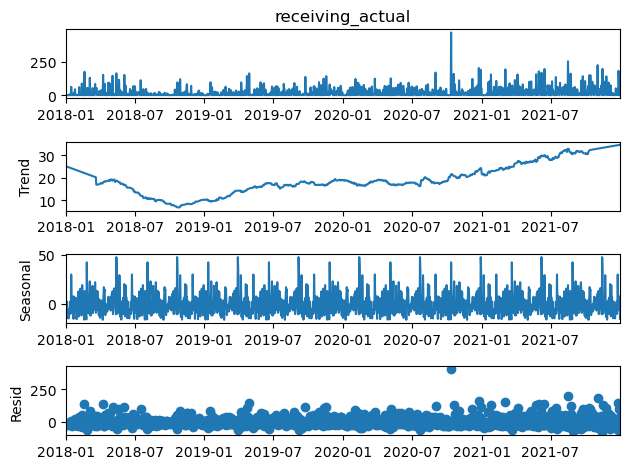

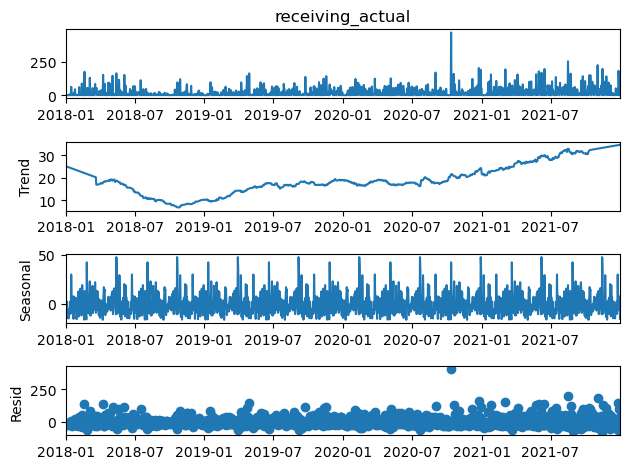

In [58]:
sd.plot()

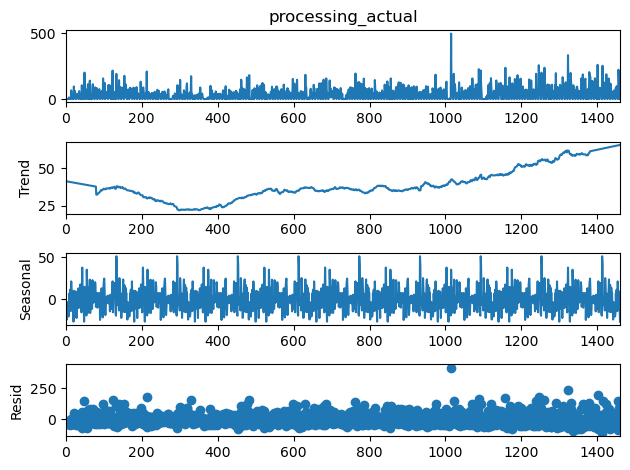

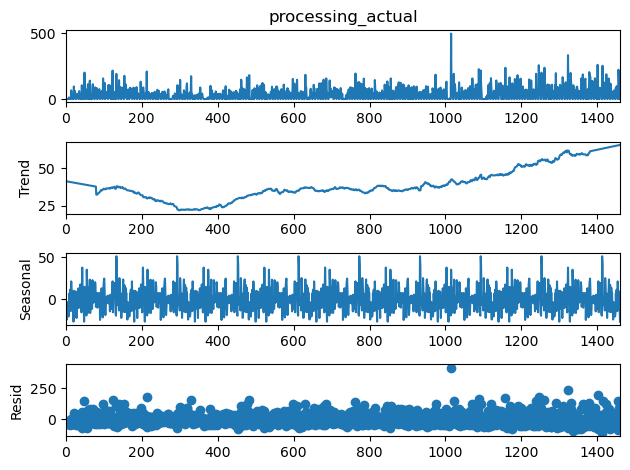

In [282]:
sd = seasonal_decompose(dfs['Урал']['processing_actual'], model = 'additive', period = 160, extrapolate_trend = 'freq')
sd.plot()

In [40]:
from tsai.all import *
my_setup()

os              : macOS-12.0.1-arm64-arm-64bit
python          : 3.9.13
tsai            : 0.3.3
fastai          : 2.7.9
fastcore        : 1.5.27
torch           : 1.12.1
device          : cpu
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


In [41]:
target_col = "keeping_actual"

In [42]:
dfs['Урал'] = dfs['Урал'].drop(columns = ['date'])

In [43]:
list(dfs['Урал'].columns)

['keeping_actual',
 'keeping_reserved',
 'processing_actual',
 'receiving_actual',
 'shipment_actual',
 'processing_reserved']

In [44]:
feature_cols = list(dfs['Урал'].columns)
target_col_id = feature_cols.index(target_col)

In [45]:
data = dfs['Урал'].to_numpy()
wl = 160
horizon = 84
stride = 1
X, y = SlidingWindow(wl, horizon = horizon, stride=stride, get_y=[target_col_id], get_x = list(range(len(feature_cols))))(data)

In [30]:
len(X)

1218

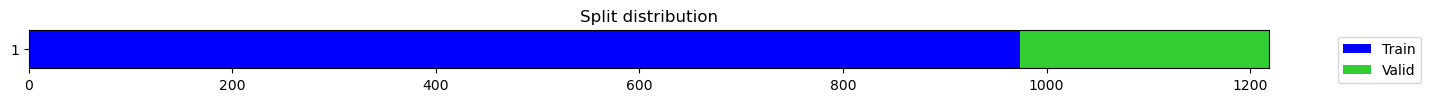

In [46]:
splits = TimeSplitter(valid_size = 0.2)(y)

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,5398711.500000,10492093.000000,0.999477,3239.150146,3220.177490,00:25
1,5331668.500000,10326291.000000,0.992175,3213.454834,3195.632568,00:25
2,5194224.500000,9828440.000000,0.969297,3135.034424,3119.688965,00:25
3,4959071.500000,9682847.000000,0.960822,3111.727539,3094.565430,00:25
4,4583024.000000,7596520.000000,0.854444,2756.178711,2745.510742,00:25
5,4063891.500000,7291818.000000,0.838678,2700.336670,2690.755371,00:25
6,3422078.500000,6785738.500000,0.807457,2604.944824,2583.181152,00:25
7,2728924.500000,2614860.000000,0.499954,1617.052856,1600.926270,00:25
8,2082119.000000,2912539.000000,0.517331,1706.616333,1617.569702,00:24
9,1543933.250000,2632218.750000,0.500153,1622.411377,1590.583984,00:24


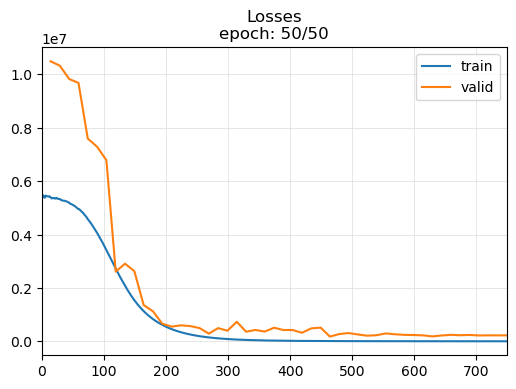

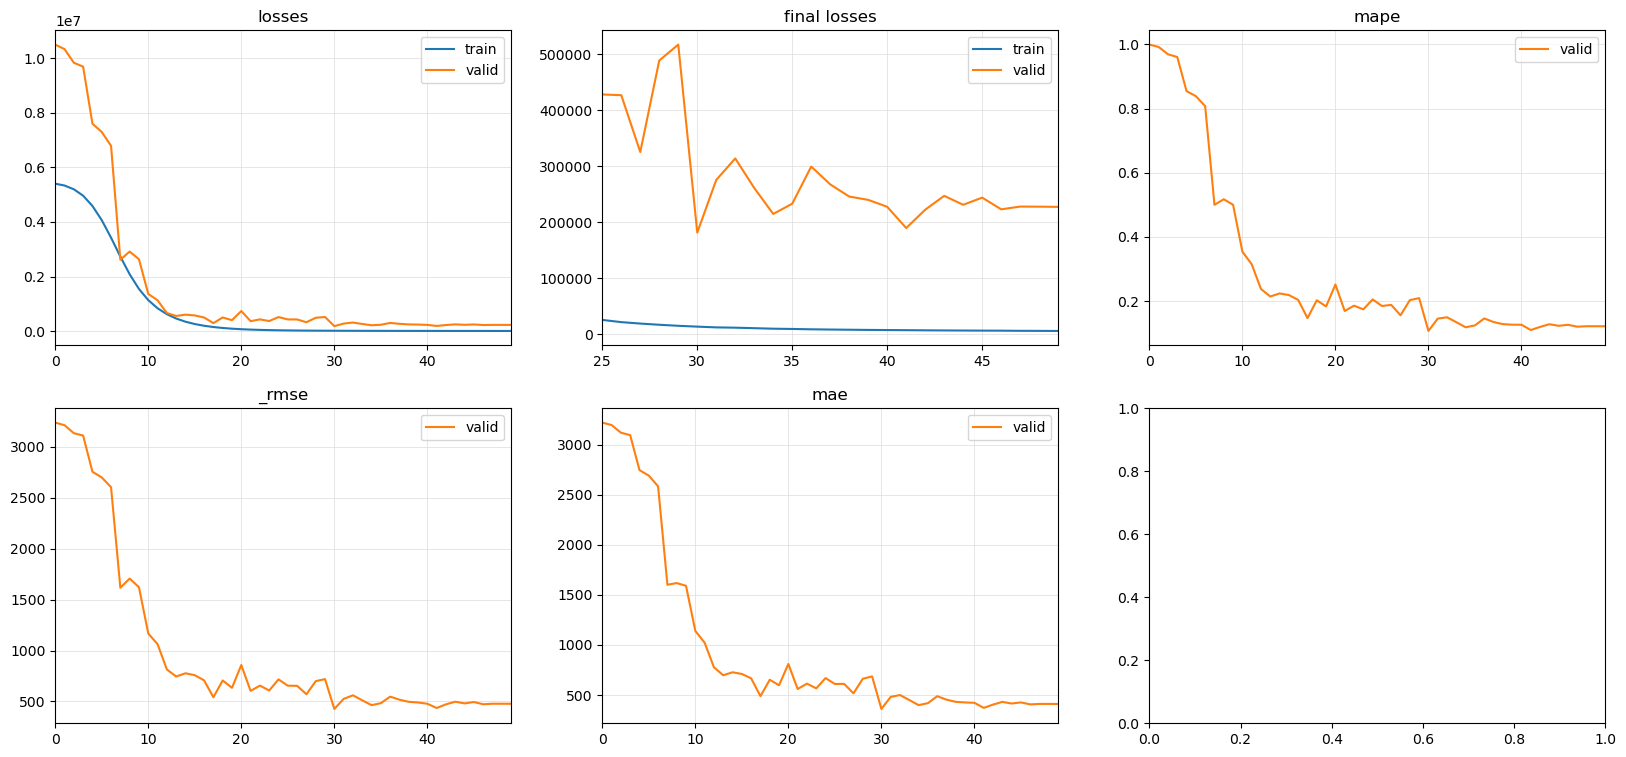

In [32]:
learn =  TSForecaster(X, y, arch_config = {'fc_dropout' : 0.5, 'nf' : 64},splits=splits, bs=[64, 128], batch_tfms=TSStandardize(by_sample=True), arch=InceptionTimePlus, cbs=ShowGraph(), metrics = [mape, rmse, mae])
learn.fit_one_cycle(50, 1e-3)

In [14]:
learn.save_all("/Users/tainella/Documents/MTC")

In [15]:
del learn

In [21]:
learn = load_learner("/Users/tainella/Documents/MTC/МСК_хранение/learner.pkl")

In [25]:
y_pred = learn.get_X_preds(X[splits[1]])

In [28]:
index_pred = 1
y_pred = learn.get_X_preds(np.array([X[splits[1]][index_pred]]))

In [29]:
y_gt = y[splits[1]][index_pred]

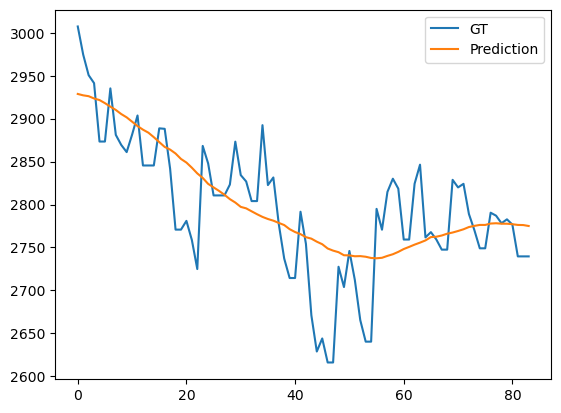

In [41]:
plt.plot(y_gt, label = "GT")
plt.plot(y_pred[0][0], label = "Prediction")
plt.legend()

In [37]:
y_pred[0][0]

TensorBase([2928.7617, 2927.1484, 2926.1711, 2923.4819, 2921.6677, 2918.0547,
            2913.9819, 2910.1416, 2905.3608, 2901.5186, 2896.4597, 2891.3806,
            2887.1873, 2883.6714, 2878.4180, 2872.7024, 2867.0759, 2863.9521,
            2859.4175, 2853.0754, 2848.8777, 2842.8782, 2836.2559, 2830.9917,
            2824.0408, 2819.9419, 2815.8755, 2811.3774, 2806.2773, 2802.3013,
            2797.2698, 2795.5376, 2792.0908, 2788.7207, 2785.5977, 2783.1489,
            2781.1970, 2778.6016, 2776.1069, 2771.3159, 2767.9624, 2765.5146,
            2761.9678, 2760.2642, 2756.7310, 2753.7700, 2748.7993, 2746.3218,
            2744.5015, 2740.9297, 2740.7964, 2739.7524, 2739.9351, 2739.1982,
            2737.7490, 2737.4121, 2737.9746, 2740.1919, 2742.1108, 2744.8701,
            2748.1738, 2750.6702, 2753.3049, 2755.6328, 2758.2046, 2762.0830,
            2762.5132, 2763.9243, 2766.0281, 2767.3943, 2769.1921, 2771.1714,
            2773.8022, 2775.1235, 2776.2466, 2776.2476, 2777.862

### Создаем для удобства функцию для обучения, ставим корректные фичи для обучения: фактические приход и уход

In [125]:
def train(name, skl_type, path_save, epoches = 50, wl = 160, nf = 64):
    '''
        name = ['МСК', 'Урал', 'СЗ'] - имя склада
        skl_type = ['keeping_actual' , 'processing_actual'] - тип 
    '''
    
    #print(dfs[name]['keeping_actual'].dtype)
    if 'date' in list(dfs[name].columns):
        dfs[name] = dfs[name].drop(columns = ['date'])
    data = dfs[name].to_numpy()
    #print(data)
    
    target_col = skl_type
    feature_cols = list(dfs[name].columns)
    target_col_id = feature_cols.index(target_col)
    feature_cols = ["receiving_actual", "shipment_actual"]
    
    horizon = 84
    stride = 1
    
    X, y = SlidingWindow(wl, horizon = horizon, stride=stride, get_y=[target_col_id], get_x = list(range(len(feature_cols))))(data)
    
    splits = TimeSplitter(valid_size = 0.2)(y)
    
    learn =  TSForecaster(X, y, arch_config = {'fc_dropout' : 0.5, 'nf' : nf},splits=splits, bs=[64, 128], batch_tfms=TSStandardize(by_sample=True), arch=InceptionTimePlus, cbs=ShowGraph(), metrics = [mape, rmse, mae])
    learn.fit_one_cycle(epoches, 1e-3)
    
    learn.save_all(path_save)

float64
[[1.61192e+03 1.50000e+03 0.00000e+00 0.00000e+00 0.00000e+00 8.00000e+02]
 [1.61192e+03 1.50000e+03 0.00000e+00 0.00000e+00 0.00000e+00 8.00000e+02]
 [1.61192e+03 1.50000e+03 0.00000e+00 0.00000e+00 0.00000e+00 8.00000e+02]
 ...
 [4.09292e+03 2.60000e+03 5.94800e+01 2.59000e+00 5.68900e+01 9.00000e+02]
 [4.10190e+03 2.60000e+03 9.44800e+01 6.86000e+01 2.58900e+01 9.00000e+02]
 [4.07601e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 9.00000e+02]]


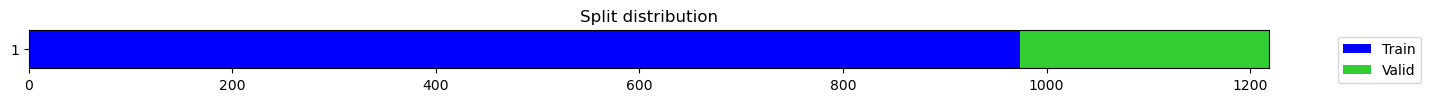

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,5396742.500000,10470454.000000,0.998410,3235.808105,3216.798584,00:24
1,5318622.000000,10198178.000000,0.985255,3193.458740,3174.547607,00:24
2,5190098.500000,9662858.000000,0.958334,3108.513916,3088.924805,00:24
3,4955966.000000,8241157.000000,0.885738,2870.741455,2853.624023,00:24
4,4591717.000000,6893821.000000,0.807693,2625.608643,2605.655518,00:24
5,4093431.000000,5245829.000000,0.704730,2290.377686,2271.466797,00:24
6,3483510.250000,4780789.500000,0.670990,2186.501709,2163.637451,00:24
7,2818582.750000,2444435.500000,0.475226,1563.469116,1530.837036,00:25
8,2175516.000000,1795522.625000,0.398649,1339.971069,1296.302002,00:25
9,1629658.750000,2224722.500000,0.450170,1491.550293,1460.541870,00:24


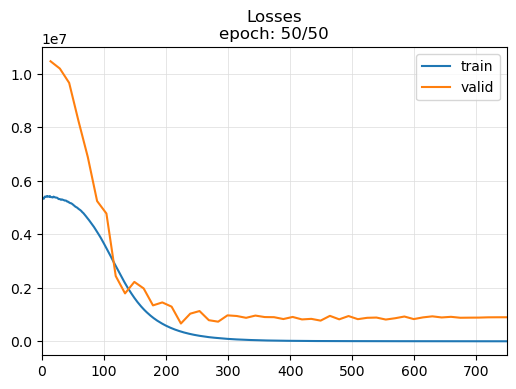

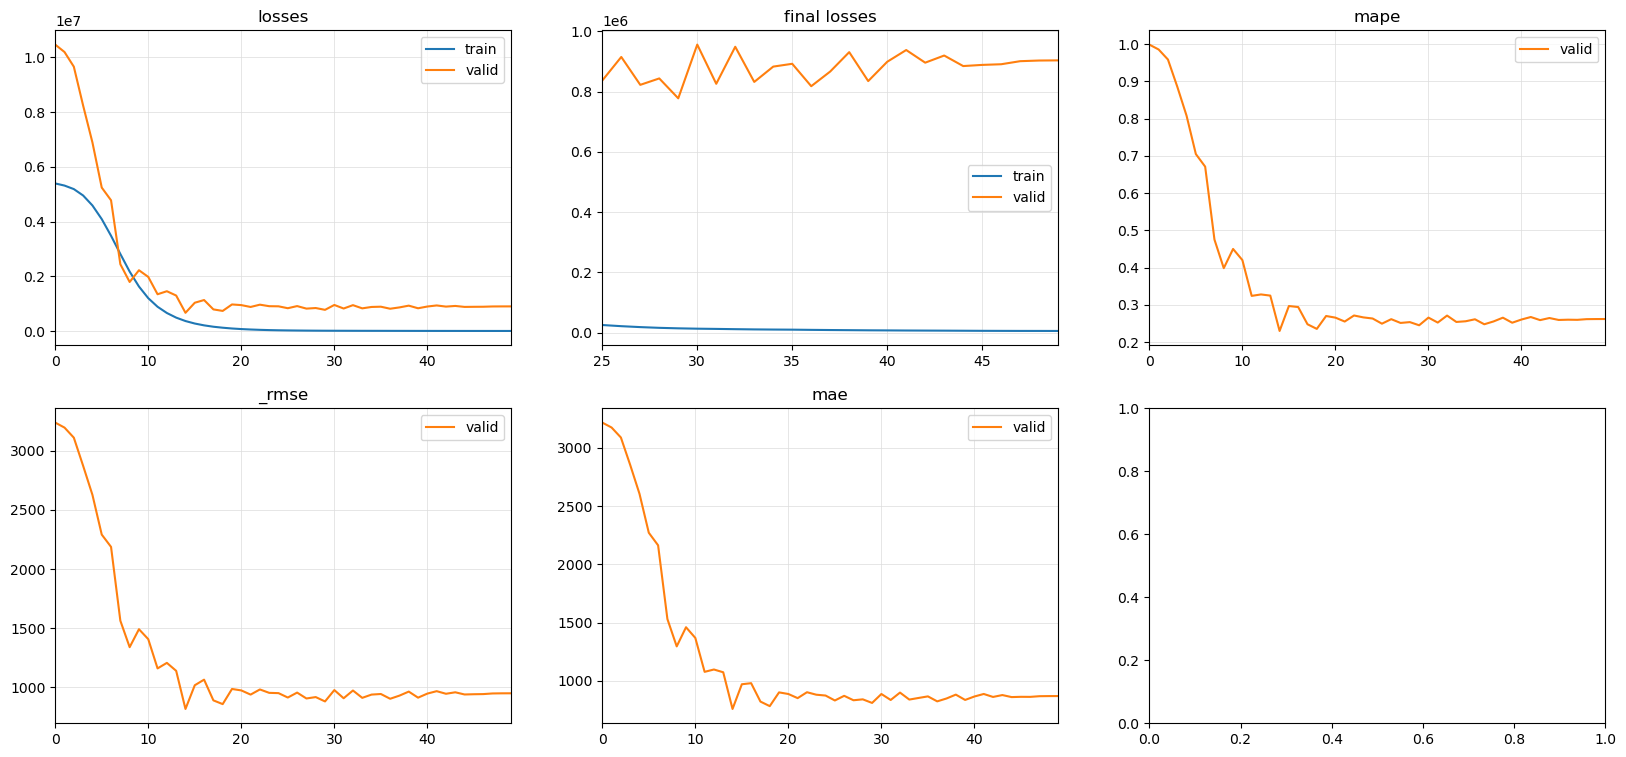

In [94]:
train("Урал", "keeping_actual", "/Users/tainella/Documents/MTC/Урал_хранение")

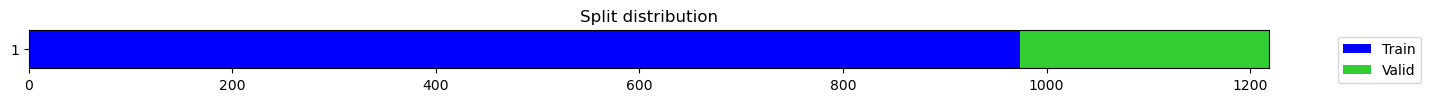

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,2461.049805,6263.743652,168334336.000000,79.143822,54.664280,00:25
1,2061.688232,4382.553223,930186240.000000,66.200859,46.956329,00:25
2,1915.742920,3790.224121,1412938240.000000,61.564796,45.564846,00:25
3,1827.270752,3732.519043,2096073088.000000,61.094345,49.176582,00:25
4,1750.222900,3888.112549,855761344.000000,62.354729,42.830997,00:24
5,1624.717285,3170.950928,405105248.000000,56.311199,35.535133,00:24
6,1488.705811,3036.415039,450193696.000000,55.103676,35.220997,00:24
7,1373.846558,3147.942139,342803136.000000,56.106525,34.732674,00:24
8,1265.883057,3015.326416,401313632.000000,54.911987,34.213650,00:25
9,1161.307983,2989.731445,426051584.000000,54.678436,34.282642,00:24


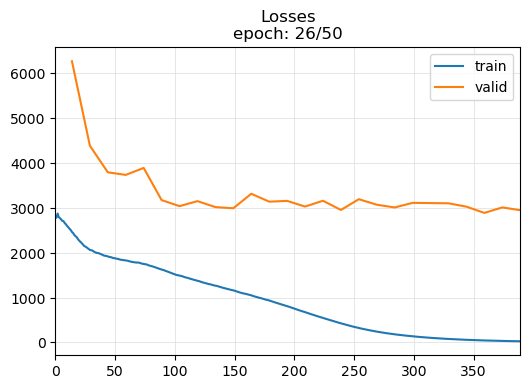

KeyboardInterrupt: 

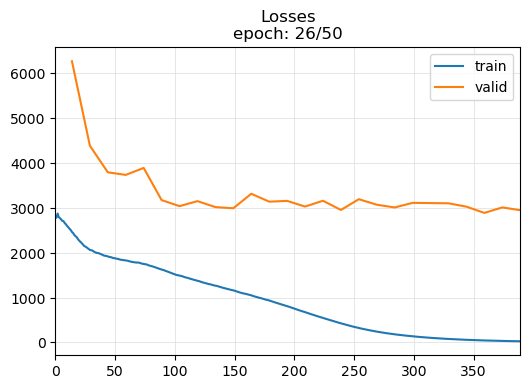

In [120]:
train("Урал", "processing_actual", "/Users/tainella/Documents/MTC/Урал_обработка")

### mape слишком большое, не получается предсказать обработку только по суммарному приходу и уходу на склад

float64
[[ 4690.5   6000.       0.       0.       0.    6000.  ]
 [ 4690.5   6000.       0.       0.       0.    6000.  ]
 [ 4690.5   6000.       0.       0.       0.    6000.  ]
 ...
 [10543.22 10800.     423.23   155.16   268.07  6800.  ]
 [10448.22 10800.     276.7    173.08   103.62  6800.  ]
 [10421.97 10800.     386.44    80.21   306.24  6800.  ]]


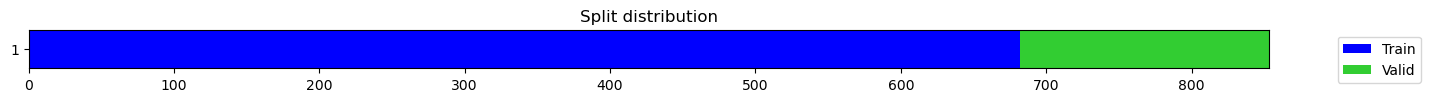

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,31200738.000000,51493404.000000,0.999600,7175.890137,7122.465820,00:16
1,31127156.000000,51317232.000000,0.997980,7163.604492,7110.588379,00:17
2,30944062.000000,50547324.000000,0.990696,7109.664551,7057.841309,00:16
3,30612914.000000,49370832.000000,0.979112,7026.437988,6975.251953,00:16
4,30101580.000000,46930388.000000,0.953222,6850.575684,6795.870117,00:17
5,29368670.000000,43287192.000000,0.914784,6579.300781,6524.448730,00:17
6,28334678.000000,41006160.000000,0.889493,6403.605469,6347.144043,00:16
7,26985436.000000,36749472.000000,0.843828,6062.133789,6014.520020,00:16
8,25295950.000000,31254648.000000,0.774838,5590.585449,5534.746582,00:16
9,23341800.000000,24387582.000000,0.686760,4938.378418,4895.630371,00:16


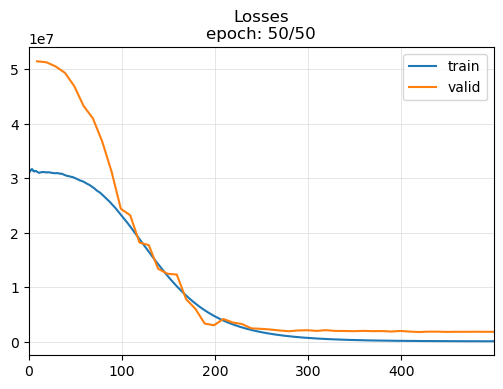

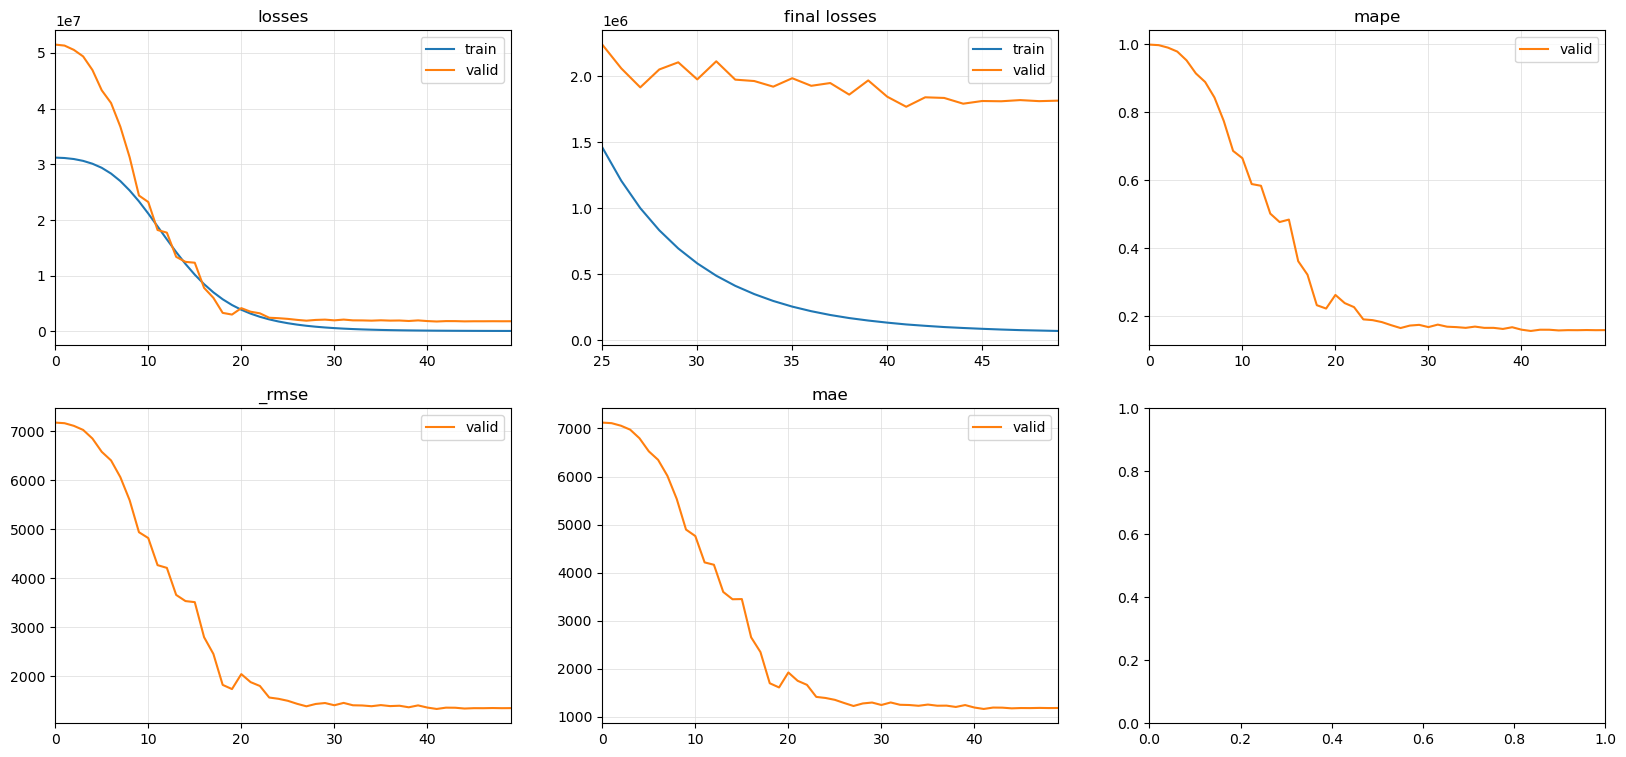

In [93]:
train("МСК", "keeping_actual", "/Users/tainella/Documents/MTC/МСК_хранение")

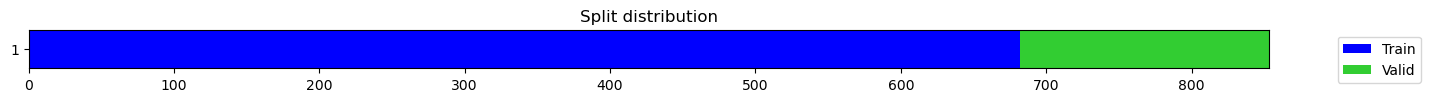

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,5332.559082,9747.710938,27924540.000000,98.730499,71.289200,00:17
1,4780.804199,9253.753906,107042592.000000,96.196434,69.380646,00:17
2,4336.902344,5377.065918,1057607232.000000,73.328484,55.181431,00:17
3,4148.273438,6728.276367,614704768.000000,82.026070,59.416306,00:17
4,3999.103271,5523.243652,991262016.000000,74.318527,55.539818,00:17


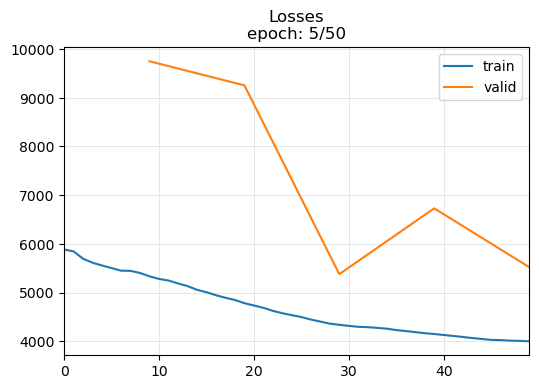

KeyboardInterrupt: 

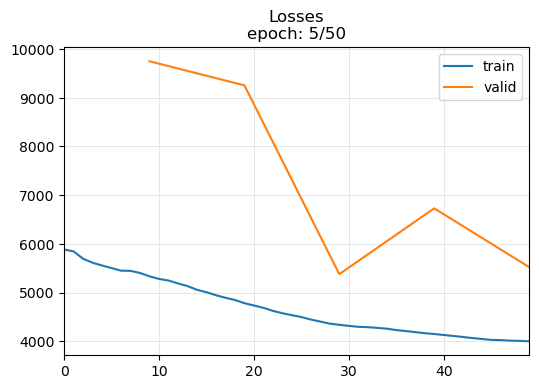

In [7]:
train("МСК", "processing_actual", "/Users/tainella/Documents/MTC/МСК_обработка")

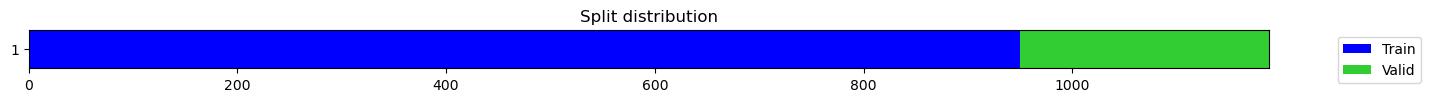

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,25395080.000000,44078888.000000,0.999506,6639.193848,6633.667969,00:12
1,25339328.000000,43914396.000000,0.997637,6626.793457,6621.268066,00:12
2,25252192.000000,43532376.000000,0.993292,6597.906738,6592.416016,00:12
3,24913108.000000,43273088.000000,0.990240,6578.228027,6572.454590,00:12
4,24345710.000000,42811804.000000,0.984705,6543.072754,6536.454590,00:12
5,23452316.000000,42053536.000000,0.975481,6484.869629,6476.327637,00:12
6,22258842.000000,39937372.000000,0.948921,6319.602051,6303.593262,00:12
7,20673410.000000,40769560.000000,0.958249,6385.104492,6365.720215,00:12
8,18840050.000000,38679368.000000,0.928939,6219.273926,6175.762695,00:12
9,16738399.000000,37986932.000000,0.917531,6163.354004,6102.518066,00:12


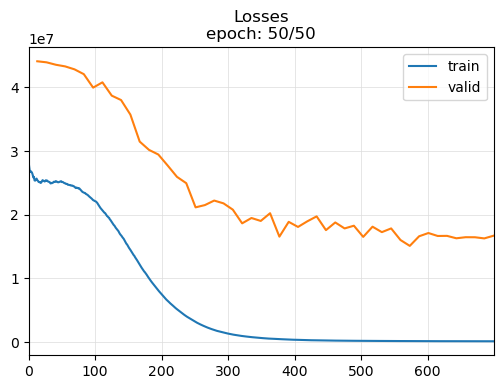

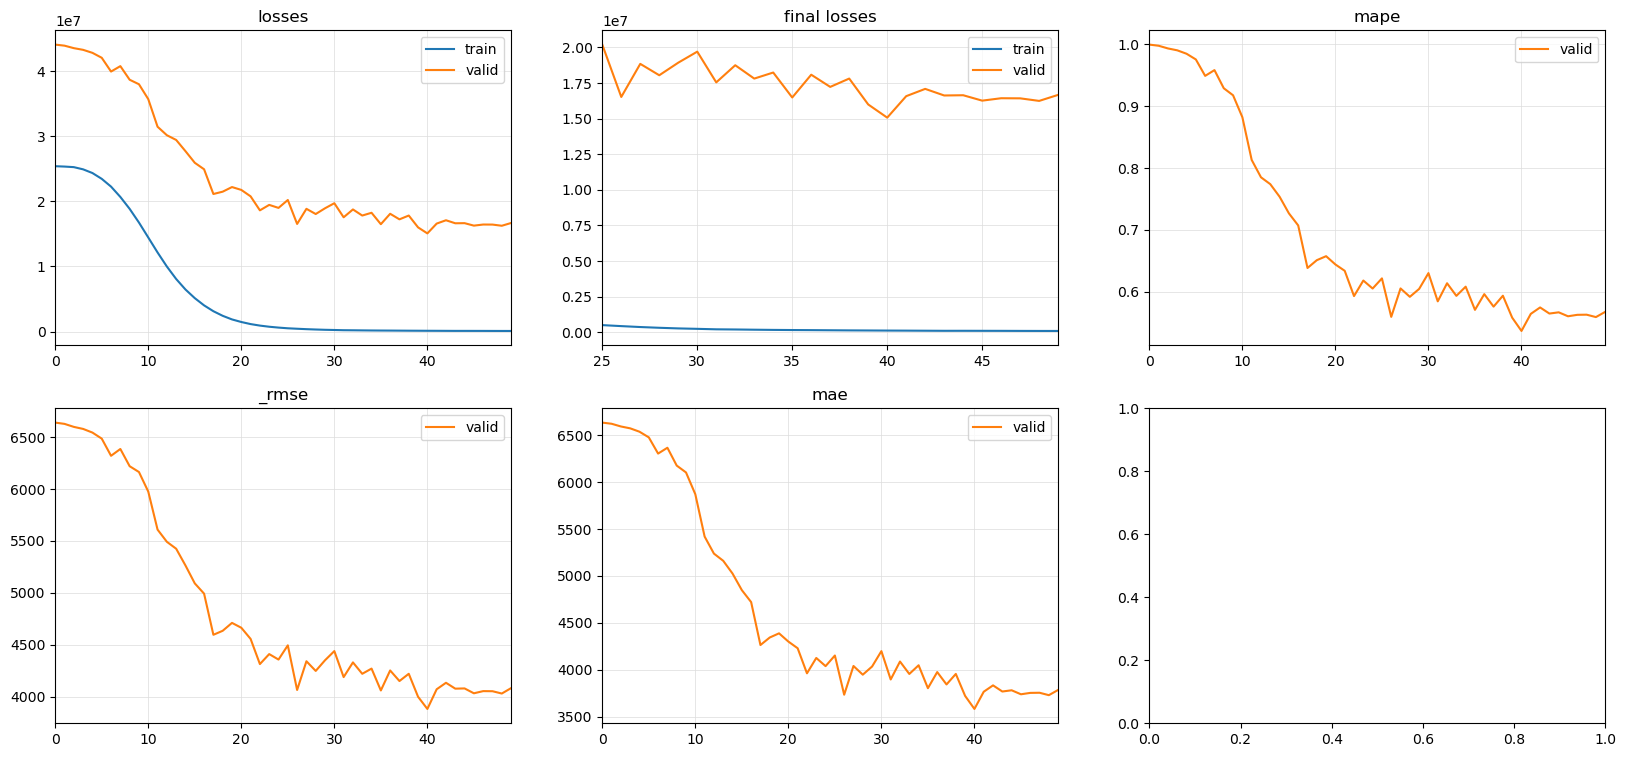

In [126]:
train("СЗ", "keeping_actual", "/Users/tainella/Documents/MTC/СЗ_хранение", wl = 190, epoches = 50, nf = 32)

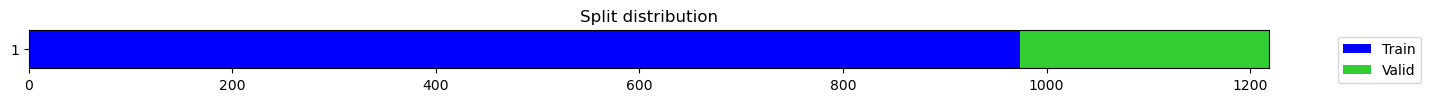

epoch,train_loss,valid_loss,mape,_rmse,mae,time
0,11835.947266,6968.061523,161760512.000000,83.474915,55.745934,00:25
1,10133.915039,5398.997070,783983680.000000,73.477867,51.511574,00:25


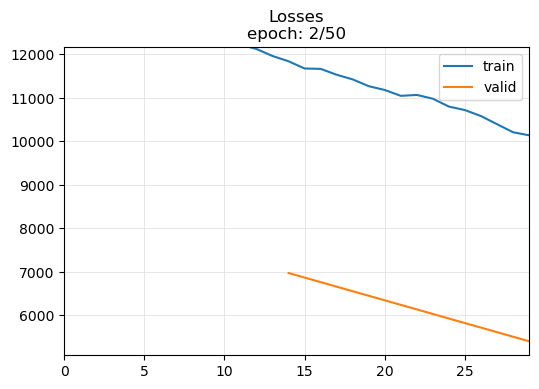

KeyboardInterrupt: 

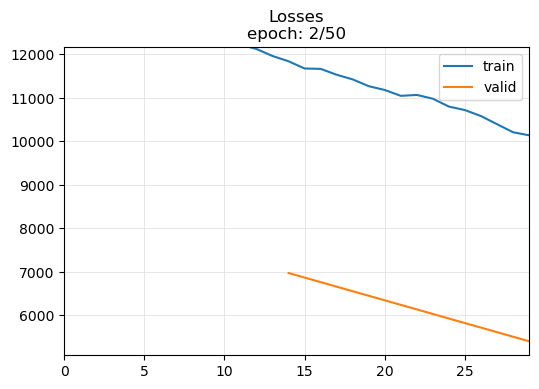

In [123]:
train("СЗ", "processing_actual", "/Users/tainella/Documents/MTC/СЗ_обработка")

### Посмотрим насколько ошибались в это время логисты МТС

In [102]:
from sklearn.metrics import mean_absolute_percentage_error

In [104]:
ural_keeping_error = mean_absolute_percentage_error(dfs['Урал']['keeping_actual'], dfs['Урал']['keeping_reserved'])
ural_processing_error = mean_absolute_percentage_error(dfs['Урал']['processing_actual'], dfs['Урал']['processing_reserved'])

msk_keeping_error = mean_absolute_percentage_error(dfs['МСК']['keeping_actual'], dfs['МСК']['keeping_reserved'])
msk_processing_error = mean_absolute_percentage_error(dfs['МСК']['processing_actual'], dfs['МСК']['processing_reserved'])


cs_keeping_error = mean_absolute_percentage_error(dfs['СЗ']['keeping_actual'], dfs['СЗ']['keeping_reserved'])
cs_processing_error = mean_absolute_percentage_error(dfs['СЗ']['processing_actual'], dfs['СЗ']['processing_reserved'])

In [105]:
print("ural_keeping_error", ural_keeping_error)
print("ural_processing_error", ural_processing_error)
print("msk_keeping_error", msk_keeping_error)
print("msk_processing_error", msk_processing_error)
print("cs_keeping_error", cs_keeping_error)
print("cs_processing_error", cs_processing_error)

ural_keeping_error 0.12413716748481211
ural_processing_error 1.5056695674121277e+18
msk_keeping_error 0.15416679616685394
msk_processing_error 5.890428892185774e+18
cs_keeping_error 0.1827492983274362
cs_processing_error 2.6627031883111803e+18


### Предсказания на 3 месяца вперед для выдачи решения

In [212]:
import json
import datetime
from datetime import timedelta

In [253]:
def create_dict_pred(pred_y,last_date,dur,name): 
    pred=[]
    for elem in pred_y[0][0]:
        pred.append(float(elem))
    days_list=[] 
    duration = timedelta(days=dur) 
    for d in range(duration.days + 1): 
        day = last_date + timedelta(d)
        days_list.append(day.strftime("%d.%m.%Y")) 
    res = dict(zip(days_list, pred)) 
    json_object = json.dumps(res, indent=4)
 
    # Writing to sample.json
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)


In [261]:
with open('dfs_2022.pkl', 'rb') as f: 
    dfs_2022 = pickle.load(f)
dfs_2022

{'МСК': Empty DataFrame
 Columns: []
 Index: [],
 'СЗ':                     date  keeping_actual  keeping_reserved  processing_actual  \
 0    2022-01-01 00:00:00         6980.78               0.0                0.0   
 1    2022-01-02 00:00:00         6980.78               0.0                0.0   
 2    2022-01-03 00:00:00         6980.78               0.0                0.0   
 3    2022-01-04 00:00:00         6980.78               0.0                0.0   
 4    2022-01-05 00:00:00         6980.78               0.0                0.0   
 ..                   ...             ...               ...                ...   
 361  2022-12-28 00:00:00            0.00               0.0                0.0   
 362  2022-12-29 00:00:00            0.00               0.0                0.0   
 363  2022-12-30 00:00:00            0.00               0.0                0.0   
 364  2022-12-31 00:00:00            0.00               0.0                0.0   
 365                  0.0            0.00  

In [279]:
pd.to_datetime('2022-12-28 00:00:00')

Timestamp('2022-12-28 00:00:00')

In [232]:
def predict_and_save(name, skl_type, path_load,dfs): 
    ''' 
        name = ['МСК', 'Урал', 'СЗ'] - имя склада 
        skl_type = ['keeping_actual' , 'processing_actual'] - тип  
    ''' 
    
    if 'date' in list(dfs[name].columns): 
        dfs[name] = dfs[name].drop(columns = ['date']) 
    
    
    data = dfs[name].to_numpy() 
    
    target_col = skl_type 
    feature_cols = list(dfs[name].columns) 
    target_col_id = feature_cols.index(target_col) 
    feature_cols = ["receiving_actual", "shipment_actual"] 
    learn = load_learner(path)
    
    X, y = SlidingWindow(wl, horizon = horizon, stride=stride, get_y=[target_col_id], get_x = list(range(len(feature_cols))))(data) 
    index_pred = 1
    y_pred = learn.get_X_preds(np.array([X[index_pred]]))
    y_gt = y[index_pred]
    plt.plot(y_gt, label = "GT") 
    plt.plot(y_pred[0][0], label = "Prediction") 
    plt.legend()
    create_dict_pred(y_pred,pd.Timestamp('2022-09-02 00:00:00'),84,f"{name}_{skl_type}")

In [205]:
path="/Users/tainella/Documents/MTC/МСК_хранение/learner.pkl"

[6530.9501953125, 6531.1455078125, 6529.8544921875, 6530.7099609375, 6527.26806640625, 6524.8154296875, 6523.244140625, 6519.83154296875, 6519.6201171875, 6517.3115234375, 6514.61474609375, 6509.60546875, 6509.0224609375, 6505.78515625, 6502.3623046875, 6501.9501953125, 6497.96142578125, 6497.185546875, 6493.1982421875, 6493.623046875, 6491.9951171875, 6491.1845703125, 6490.978515625, 6488.7197265625, 6487.04736328125, 6488.8623046875, 6484.376953125, 6483.30322265625, 6481.79833984375, 6483.1337890625, 6482.0185546875, 6479.4755859375, 6480.54443359375, 6475.646484375, 6475.24609375, 6474.0517578125, 6471.45849609375, 6466.8564453125, 6464.728515625, 6463.5693359375, 6460.369140625, 6458.064453125, 6457.03515625, 6455.26171875, 6452.453125, 6449.63818359375, 6446.32080078125, 6444.75, 6439.8505859375, 6438.4716796875, 6433.74462890625, 6431.095703125, 6429.70703125, 6424.947265625, 6420.9267578125, 6417.25390625, 6413.00244140625, 6409.55078125, 6402.7900390625, 6396.61865234375, 6391

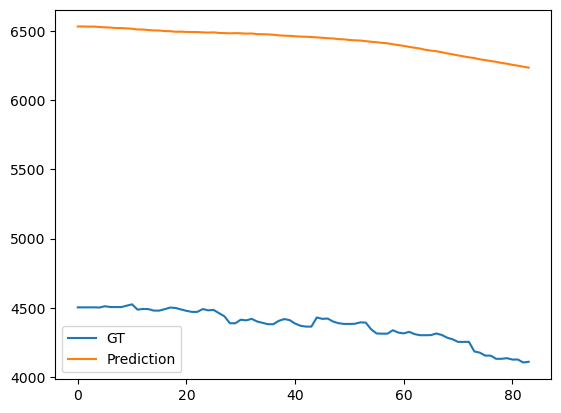

In [257]:
predict_and_save(name='Урал',skl_type='keeping_actual',path_load=path,dfs=dfs_2022)

In [169]:
dfs

{'МСК':            date  keeping_actual  keeping_reserved  processing_actual  \
 0    2018-01-01         4690.50              6000               0.00   
 1    2018-01-02         4690.50              6000               0.00   
 2    2018-01-03         4690.50              6000               0.00   
 3    2018-01-04         4690.50              6000               0.00   
 4    2018-01-05         4690.50              6000               0.00   
 ...         ...             ...               ...                ...   
 1091 2020-12-27        10366.74             10800             216.05   
 1092 2020-12-28        10503.06             10800             276.93   
 1093 2020-12-29        10543.22             10800             423.23   
 1094 2020-12-30        10448.22             10800             276.70   
 1095 2020-12-31        10421.97             10800             386.44   
 
       receiving_actual  shipment_actual  processing_reserved  
 0                 0.00             0.00           